In [1]:
import os
import random
import cv2
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
from sklearn.model_selection import train_test_split

from tensorflow.math import log, reduce_mean
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

!pip install patchify
from patchify import patchify

import matplotlib.patches as mpatches

# 1 Patches

In [2]:
root_directory = "/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/"
patch_size = 256

In [3]:
image_dataset = []
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        images = os.listdir(path)
        images.sort()
        for i, image_name in enumerate(images):
            if image_name.endswith(".jpg"):
                
                image = cv2.imread(path+'/'+image_name, 1)
                SIZE_X = (image.shape[1]//patch_size)*patch_size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size
                image = Image.fromarray(image)
                image = image.crop((0,0,SIZE_X,SIZE_Y))
                image = np.array(image)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
                
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):  
                        single_patch_img = patches_img[i,j,0,:,:]
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        image_dataset.append(single_patch_img)

In [4]:
mask_dataset = []
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':
        masks = os.listdir(path)
        masks.sort()
        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".png"):
                
                mask = cv2.imread(path+'/'+mask_name, 1)
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size
                mask = Image.fromarray(mask)
                mask = mask.crop((0,0,SIZE_X,SIZE_Y))
                mask = np.array(mask)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)
                
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):  
                        single_patch_mask = patches_mask[i,j,0,:,:]
                        mask_dataset.append(single_patch_mask)

In [5]:
image_dataset = np.asarray(image_dataset)
mask_dataset = np.asarray(mask_dataset)

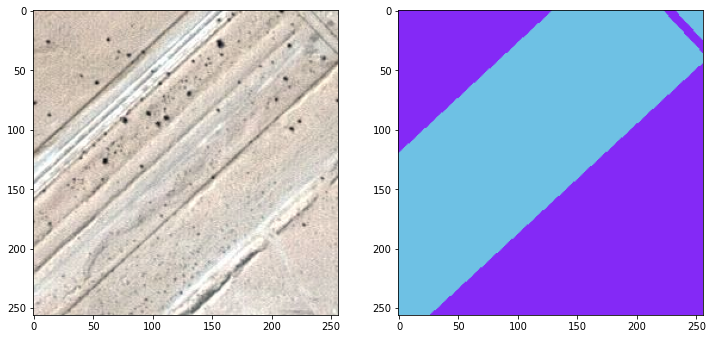

In [6]:
image_number = random.randint(0, len(image_dataset))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

# 2 Labels (RGB to categorical)

In [7]:
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

In [8]:
def rgb_to_2D_label(label):
    label_seg = np.zeros(label.shape, dtype=np.uint8)
    label_seg [np.all(label == Unlabeled, axis = -1)] = 0
    label_seg [np.all(label == Land, axis = -1)] = 1
    label_seg [np.all(label == Road, axis = -1)] = 2  
    label_seg [np.all(label == Vegetation, axis = -1)] = 4   
    label_seg [np.all(label == Water, axis = -1)] = 5
    label_seg [np.all(label == Building, axis = -1)] = 3 
    
    label_seg = label_seg[:,:,0]
    
    return label_seg

labels = []

for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)

In [9]:
labels = np.array(labels)
labels.shape

(1305, 256, 256)

In [10]:
labels_cat = to_categorical(labels)
labels_cat.shape

(1305, 256, 256, 6)

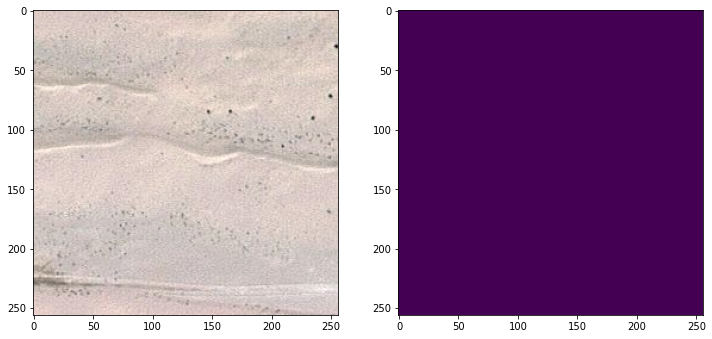

[1]
(256, 256, 3)
(256, 256)


In [11]:
image_number = random.randint(0, len(image_dataset))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number])
plt.show()

print(np.unique(labels[image_number]))


print(image_dataset[image_number].shape)
print(labels[image_number].shape)

# 3 Model

In [12]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, train_size = 0.8, test_size = 0.2, random_state = 42)

In [13]:
del image_dataset, mask_dataset, labels_cat, labels

In [14]:
import keras 
import tensorflow as tf 

def multi_unet_model(n_classes, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu',  padding='same')(c5)
    
    #Expansive path 

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu',  padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu',  padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [15]:
n_classes =  y_train.shape[-1] # without Unlabeled . two class model
model = multi_unet_model(n_classes)
model.summary()

2023-01-20 09:43:34.389298: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-20 09:43:34.485825: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-20 09:43:34.486679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

2023-01-20 09:43:34.488851: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-20 09:43:34.489243: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-20 09:43:34.490036: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-20 09:43:34.490791: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [16]:
def accuracy_with_mask(y_true, y_pred):
    return 1

In [17]:
print(X_train.shape)

(1044, 256, 256, 3)


In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True))

In [19]:
history1 = model.fit(X_train, y_train, 
                     batch_size=4,
                    verbose=1,
                    epochs=100, 
                    validation_data=(X_test, y_test)
                    )

2023-01-20 09:43:37.198912: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 821035008 exceeds 10% of free system memory.
2023-01-20 09:43:38.063990: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1642070016 exceeds 10% of free system memory.
2023-01-20 09:43:39.958738: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 821035008 exceeds 10% of free system memory.
2023-01-20 09:43:40.648381: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1642070016 exceeds 10% of free system memory.
2023-01-20 09:43:41.950120: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '
2023-01-20 09:43:44.019747: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


261/261 [==============================] - 17s 34ms/step - loss: 1.1484 - val_loss: 0.9572
Epoch 2/100
261/261 [==============================] - 8s 29ms/step - loss: 0.8566 - val_loss: 0.8291
Epoch 3/100
261/261 [==============================] - 7s 28ms/step - loss: 0.7671 - val_loss: 0.7256
Epoch 4/100
261/261 [==============================] - 7s 28ms/step - loss: 0.7211 - val_loss: 0.7522
Epoch 5/100
261/261 [==============================] - 7s 28ms/step - loss: 0.7064 - val_loss: 0.6733
Epoch 6/100
261/261 [==============================] - 8s 29ms/step - loss: 0.6783 - val_loss: 0.7025
Epoch 7/100
261/261 [==============================] - 7s 29ms/step - loss: 0.6804 - val_loss: 0.6278
Epoch 8/100
261/261 [==============================] - 8s 29ms/step - loss: 0.6570 - val_loss: 0.6252
Epoch 9/100
261/261 [==============================] - 8s 29ms/step - loss: 0.6405 - val_loss: 0.6537
Epoch 10/100
261/261 [==============================] - 8s 30ms/step - loss: 0.6167 - val_los

[28, 146, 173, 137, 216]


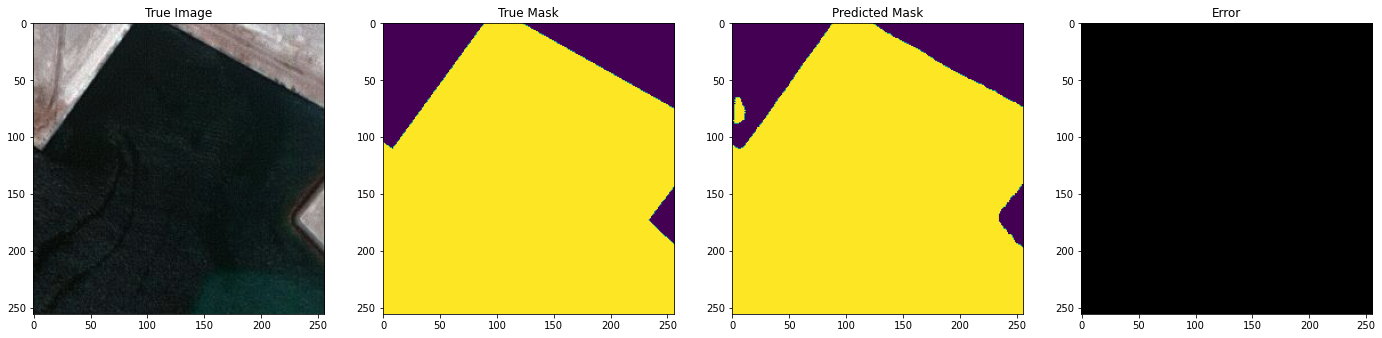

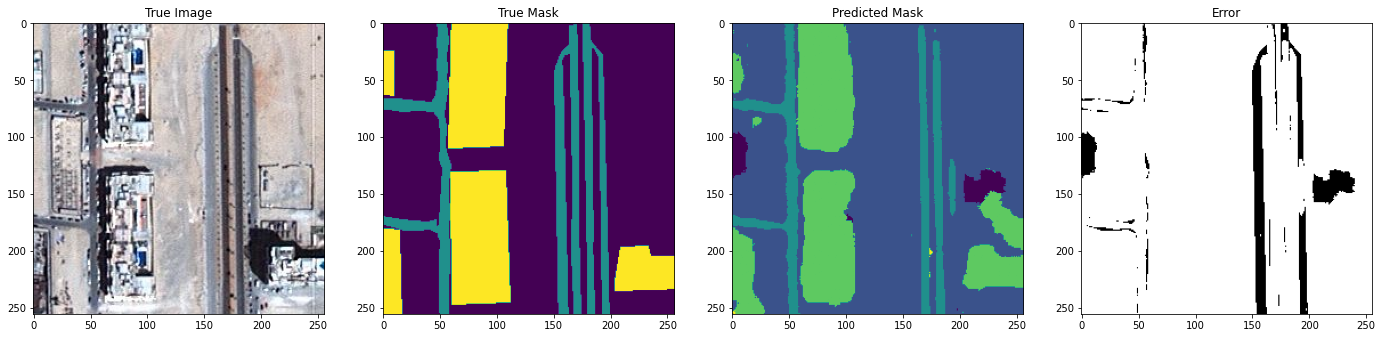

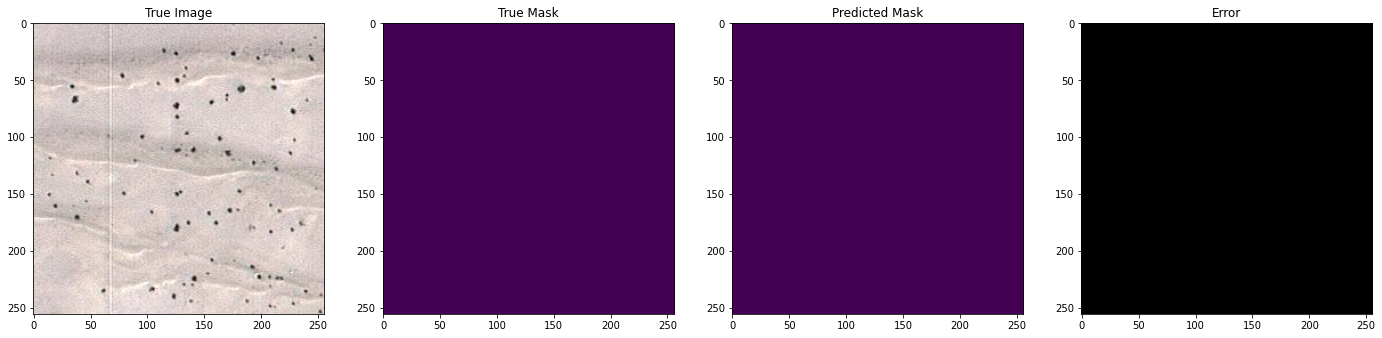

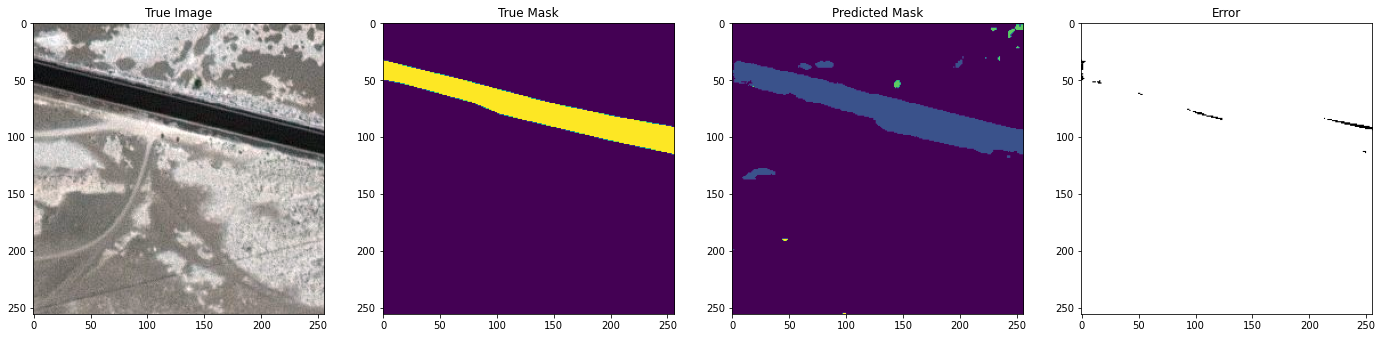

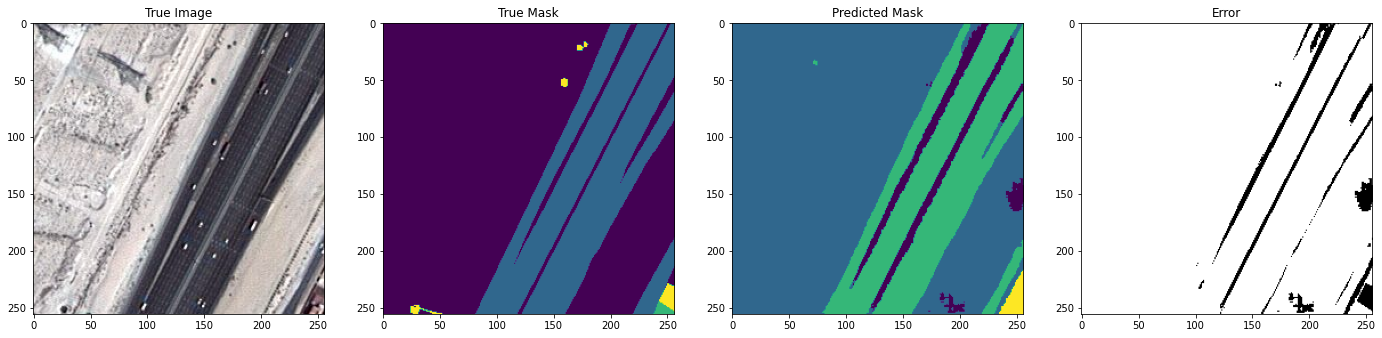

In [31]:
import random

image_numbers = random.sample(list(range(X_test.shape[0])), 5)
print(image_numbers) 

for image_number in image_numbers: 
    plt.figure(figsize=(24,6))
    plt.subplot(141)
    plt.title("True Image")
    plt.imshow(X_test[image_number])
    
    plt.subplot(142)
    plt.title("True Mask")
    true = y_test[image_number].argmax(axis=2)
    plt.imshow(true)
    
    plt.subplot(143)
    plt.title("Predicted Mask")
    prediction = model.predict(np.expand_dims(X_test[image_number], 0))[0].argmax(axis=2) + 1
    plt.imshow(prediction)
    
    plt.subplot(144)
    plt.title("Error")
    error = (true != prediction) & (true != 0)
    error = error.astype(int)
    plt.imshow(error, cmap='gray')
    
    plt.show()


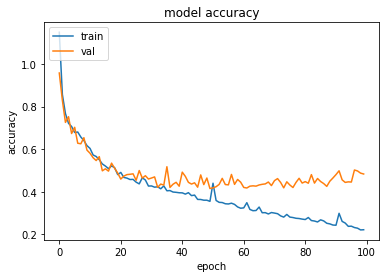

In [34]:
import seaborn as sns

plt.plot(history1.history["loss"])
plt.plot(history1.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()